In [2]:
from ray import train, tune

from hyperopt import hp

from ray.tune.search.hyperopt import HyperOptSearch

In [3]:
import dabench as dab
from dabench import vector
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.sparse.linalg import bicgstab
from scipy.linalg import inv
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy
import jax.numpy as jnp
import jax
from timeit import default_timer as timer
import inspect
import pandas as pd

from ray import train, tune
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

# Define some parameters

In [3]:
system_dim= 36
spinup_size = 14400
valid_size = 5000
test_size = 5000
nr_steps = spinup_size + valid_size + test_size
delta_t=0.01
obs_sd = 0.5
sigma_bg = 0.3
sigma_obs = 0.625
analysis_window = 0.1
analysis_time_in_window = 0.05
obs_location_count = 18
random_seed=5
num_epochs = 3
n_outer_loops = 3 #10 # Was 3
learning_rate = 2e-1
lr_decay = 0.5 # Was 0.1 for the experiment
num_runs = 5

# Function def: Backprop

In [4]:
def run_backprop_4dvar(system_dim, nr_steps, spinup_size, valid_size, test_size, test_run, delta_t, obs_location_count,
              obs_sd, sigma_bg, sigma_obs, analysis_window, analysis_time_in_window,
              random_seed, num_epochs, learning_rate, lr_decay):
    np_rng = np.random.default_rng(random_seed)
    jax.clear_backends()


    ### Nature Run
    nature_run = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t, store_as_jax=True, random_seed=random_seed)


    x0_initial = np_rng.normal(size=system_dim, scale=1)
    nature_run.generate(n_steps=nr_steps, x0 = x0_initial) 
    nr_spinup, nr_valid, nr_test = nature_run.split_train_valid_test(spinup_size, valid_size, test_size)

    if not test_run:
        nr_eval = nr_valid
    else:
        nr_eval = nr_test
    ### Observations
    # Now we can define the observer:
    obs_l96 = dab.observer.Observer(
        nr_eval, # Data generator object
        time_indices = np.arange(0, nr_eval.time_dim, 5), # Observation every other timestep
        random_location_count = obs_location_count, # Probability of picking each location in l63.system_dim for random sampling
        error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
        error_sd = obs_sd, # Standard deviation for observation error, Gaussian/Normal distribution
        random_seed=random_seed, # We can specify a random seed. Default is 99
        stationary_observers=True,
        store_as_jax=True
    )

    # Making observations
    obs_vec_l96 = obs_l96.observe()


    # Model
    model_l96 = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t, store_as_jax=True, random_seed=random_seed)

    class L96Model(dab.model.Model):                                                                       
        """Defines model wrapper for Lorenz96 to test forecasting."""
        def forecast(self, state_vec, n_steps):
            self.model_obj.generate(x0=state_vec.values, n_steps=n_steps)
            new_vals = self.model_obj.values 

            new_vec = dab.vector.StateVector(values=new_vals, store_as_jax=True)

            return new_vec

    fc_model = L96Model(model_obj=model_l96)
    
    ### Set up DA matrices
    obs_total_size = int(obs_location_count*3)
    
    H = np.zeros((obs_location_count, system_dim))
    H[np.arange(H.shape[0]), np.tile(obs_vec_l96.location_indices[0], 1)] = 1
    R = (sigma_obs**2)* np.identity(obs_total_size)
    B = (sigma_bg**2)*np.identity(system_dim)

    
    da_time_start = timer()

    
    dc = dab.dacycler.Var4DBackprop(
        system_dim=system_dim,
        delta_t=nr_eval.delta_t,
        H=H,
        B=B,
        R=R,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        lr_decay=lr_decay,
        model_obj=fc_model,
        obs_window_indices=[0,5,10],
        steps_per_window=11, # 11 instead of 10 because inclusive of 0 and 11
        )

    
    ### Execute
    cur_tstep = 0
    x0_original = nr_eval.values[cur_tstep] + np_rng.normal(size=(system_dim,), scale=1)

    x0_sv = dab.vector.StateVector(
        values=x0_original,
        store_as_jax=True)
    

    out_statevec = dc.cycle(
        input_state = x0_sv,
        start_time = nr_eval.times[cur_tstep],
        obs_vector = obs_vec_l96,
        analysis_window=analysis_window,
        timesteps=498,
        obs_error_sd=sigma_obs,
        analysis_time_in_window=analysis_time_in_window)
    
    da_time = timer()-da_time_start

    rmse = np.sqrt(np.mean(np.square(nr_eval.values[:-20] - out_statevec.values)))
    
    
    return out_statevec, rmse, obs_vec_l96, nr_eval, da_time

# Function def: 4DVar

In [5]:
def run_4dvar(system_dim, nr_steps, spinup_size, valid_size, test_run, test_size, delta_t, obs_location_count, 
              obs_sd, sigma_bg, sigma_obs, analysis_window, analysis_time_in_window,
              random_seed, n_outer_loops):
    np_rng = np.random.default_rng(random_seed)
    jax.clear_backends()


    ### Nature Run
    nature_run = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t, store_as_jax=True, random_seed=random_seed)
#     x0_initial = np.concatenate([np.array([0.01]),
#                                   np.zeros(system_dim-1)])
    x0_initial = np_rng.normal(size=system_dim, scale=1)
    nature_run.generate(n_steps=nr_steps, x0 = x0_initial) #np_rng.normal(size=system_dim))
    nr_spinup, nr_valid, nr_test = nature_run.split_train_valid_test(spinup_size, valid_size, test_size)

    if not test_run:
        nr_eval = nr_valid
    else:
        nr_eval = nr_test
    ### Observations
    # Now we can define the observer:
    obs_l96 = dab.observer.Observer(
        nr_eval, # Data generator object
        time_indices = np.arange(0, nr_eval.time_dim, 5), # Observation every other timestep
        random_location_count = obs_location_count, # Probability of picking each location in l63.system_dim for random sampling
        error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
        error_sd = obs_sd, # Standard deviation for observation error, Gaussian/Normal distribution
        random_seed=random_seed, # We can specify a random seed. Default is 99
        stationary_observers=True,
        store_as_jax=True
    )

    # Making observations
    obs_vec_l96 = obs_l96.observe()
    # Model
    model_l96 = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t, store_as_jax=True, random_seed=random_seed)

    class L96Model(dab.model.Model):                                                                       
        """Defines model wrapper for Lorenz96 to test forecasting."""
        def forecast(self, state_vec,n_steps):
            self.model_obj.generate(x0=state_vec.values, n_steps=n_steps)
            new_vals = self.model_obj.values 

            new_vec = dab.vector.StateVector(values=new_vals, store_as_jax=True)

            return new_vec

        def compute_tlm(self, state_vec, n_steps):
            """For 4DVar. Not used for Backprop4DVar"""
            M = self.model_obj.generate(n_steps=n_steps, x0=state_vec.values, return_tlm=True)
            return M, self.model_obj.values

    fc_model = L96Model(model_obj=model_l96)
    
    ### Set up DA matrices
    H = np.zeros((obs_location_count, system_dim))
    H[np.arange(H.shape[0]), obs_vec_l96.location_indices[0]] = 1
    R = (sigma_obs**2)*np.eye(H.shape[0])
    B = np.identity(system_dim)*(sigma_bg**2)
    Bsqrt = np.sqrt(B)
    
    da_time_start = timer()
    
    ### Define 4dvar
    dc = dab.dacycler.Var4D(
    system_dim=system_dim,
    delta_t=nature_run.delta_t,
    H=H,
    B=B,
    R=R,
    Bsqrt=Bsqrt,
    n_outer_loops=n_outer_loops,
    model_obj=fc_model,
    obs_window_indices=[0,5, 10],
    steps_per_window=11, # 11 instead of 10 because inclusive of 0 and 11
    )
    
    ### Execute
    cur_tstep = 0
    x0_original = nr_eval.values[cur_tstep] + np_rng.normal(size=(system_dim,), scale=1)

    x0_sv = dab.vector.StateVector(
        values=x0_original,
        store_as_jax=True)

    out_statevec_4dvar = dc.cycle(
        input_state = x0_sv,
        start_time = nr_eval.times[cur_tstep],
        obs_vector = obs_vec_l96,
        analysis_window=analysis_window,
        timesteps=498,
        obs_error_sd=sigma_obs,
        analysis_time_in_window=analysis_time_in_window)
    
    da_time = timer()-da_time_start
    
    rmse = np.sqrt(np.mean(np.square(nr_eval.values[:-20] - out_statevec_4dvar.values)))
    
    return out_statevec_4dvar, rmse, obs_vec_l96, nr_eval, da_time


# Validation: test some different learning rates and decays and number of epochs

### Tune

In [6]:
def train_backprop_4dvar(config, system_dim, num_obs, obs_sd):
    random_seed = system_dim 
    obs_location_count = num_obs
    run_dict = dict(
        system_dim=system_dim, 
        nr_steps=nr_steps,
        spinup_size=spinup_size,
        valid_size=valid_size,
        test_size=test_size,
        test_run=False,
        delta_t=delta_t,
        obs_location_count=obs_location_count,
        obs_sd=obs_sd,
        sigma_bg=obs_sd/1.5,
        sigma_obs=obs_sd*1.25,
        analysis_window=analysis_window,
        analysis_time_in_window=analysis_time_in_window,
        random_seed=random_seed,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        lr_decay = lr_decay)

    run_dict['learning_rate'] = config['lr']
    run_dict['lr_decay'] = config['lr_decay']
    
    out_bp, error_bp, obs_vec_l96, nr_eval, da_time = run_backprop_4dvar(**run_dict)
    
    train.report({'rmse':error_bp})
    

In [7]:
space = {
    "lr": hp.loguniform("lr", -8, -2),
    "lr_decay": hp.uniform("lr_decay", 0.1, 0.9),
}



In [8]:
all_results_df_list = []
system_dim_list = [6, 20, 36, 72, 144, 256]
for system_dim in system_dim_list:
    trainable_with_system_dim = tune.with_parameters(train_backprop_4dvar, 
                                                     system_dim=system_dim,
                                                     num_obs=int(system_dim/2),
                                                     obs_sd=0.5
                                                     )
    hyperopt_search = HyperOptSearch(space, metric="rmse", mode="min")
    tuner = tune.Tuner(
        trainable_with_system_dim,
        tune_config=tune.TuneConfig(
            num_samples=100,
            search_alg=hyperopt_search,
        ),
    )
    results = tuner.fit()

    cur_results_df = results.get_dataframe()

    cur_results_df['system_dim'] = system_dim

    all_results_df_list.append(cur_results_df)

(train_backprop_4dvar pid=1981050) [[1273.23930928 1989.24102397  915.09120369]
(train_backprop_4dvar pid=1981050)  [ 397.58027807  544.79658515  320.51044822]] [repeated 5x across cluster]
(train_backprop_4dvar pid=1981050)  ...
(train_backprop_4dvar pid=1981222) [[ 1273.23930928  1258.02553318  1245.95803237]
(train_backprop_4dvar pid=1981222)  ...
(train_backprop_4dvar pid=1981222)  [21220.83237717 20972.48371705 20774.83968192]
(train_backprop_4dvar pid=1981222)  [21531.35577711 21285.49607163 21089.81511786]
(train_backprop_4dvar pid=1981222)  [23958.12813465 23675.14032112 23450.0100861 ]]
(train_backprop_4dvar pid=1981222)  [ 3077.62506353  3030.2852259   2992.79603653] [repeated 2x across cluster]
(train_backprop_4dvar pid=1981478) [[ 1273.23930928  1222.57086223  1203.59126299]
(train_backprop_4dvar pid=1981478)  ...
(train_backprop_4dvar pid=1981478)  [24622.45546533 23619.24973579 23239.55433466] [repeated 2x across cluster]
(train_backprop_4dvar pid=1981478)  [24803.0200569

2024-01-04 19:30:50,039	ERROR tune_controller.py:1383 -- Trial task failed for trial train_backprop_4dvar_65169eb5
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=1982880, ip=192.168.0.249, actor_id=72fc65f418f250847a8f2c4101000000, repr=train_

(train_backprop_4dvar pid=1984262)  [ 840.46618438  620.42260599  571.81829901]] [repeated 7x across cluster]
(train_backprop_4dvar pid=1984262) [[1273.23930928  893.53128727  817.32538564] [repeated 4x across cluster]


2024-01-04 19:30:55,170	ERROR tune_controller.py:1383 -- Trial task failed for trial train_backprop_4dvar_e95d5be7
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=1981050, ip=192.168.0.249, actor_id=222d90a595695a2ac8467c6301000000, repr=train_

(train_backprop_4dvar pid=1981772)  [ 594.99940585  411.16063559  405.4081028 ]
(train_backprop_4dvar pid=1981772)  ... [repeated 2x across cluster]
(train_backprop_4dvar pid=1981222)  [ 395.73887993  310.99330606  304.18358177]] [repeated 9x across cluster]
(train_backprop_4dvar pid=1981222) [[1273.23930928  850.26423989  821.31012142] [repeated 2x across cluster]
(train_backprop_4dvar pid=1981222)  ...
(train_backprop_4dvar pid=1987405)  ...
(train_backprop_4dvar pid=1987405)  [ 402.75836545  298.06276228  291.52839846]] [repeated 5x across cluster]
(train_backprop_4dvar pid=1987405) [[1273.23930928  803.85007275  774.96082141]
(train_backprop_4dvar pid=1981478) [[1273.23930928 1042.85398142  976.94063226]
(train_backprop_4dvar pid=1981478)  [1229.03578171  975.85676768  906.44451818]
(train_backprop_4dvar pid=1981478)  [1534.44444247 1213.42110966 1125.92850483]
(train_backprop_4dvar pid=1981478)  [3542.54371429 2914.24981602 2728.10731462]
(train_backprop_4dvar pid=1981478)  [3727.

2024-01-04 19:31:23,347	ERROR tune_controller.py:1383 -- Trial task failed for trial train_backprop_4dvar_607a1e3c
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=1981222, ip=192.168.0.249, actor_id=25cc8a230091763d4dd8afe301000000, repr=train_

(train_backprop_4dvar pid=1988595) [[ 1273.23930928  7823.62401426  1349.49514736]
(train_backprop_4dvar pid=1988595)  ... [repeated 2x across cluster]
(train_backprop_4dvar pid=1988595)  [ 5827.48880573 40732.43136127  6455.00816731]] [repeated 9x across cluster]
(train_backprop_4dvar pid=1981772) [[1273.23930928  808.69267444  770.98541673]


2024-01-04 19:31:29,967	ERROR tune_controller.py:1383 -- Trial task failed for trial train_backprop_4dvar_2b7d50f2
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=1982547, ip=192.168.0.249, actor_id=a21de56c2524d1785a5c7c6001000000, repr=train_

(train_backprop_4dvar pid=1987405)  [16352.42490502 14384.5037839  14103.51844387]
(train_backprop_4dvar pid=1987405)  [16381.52801991 14379.77955921 14093.1216621 ]
(train_backprop_4dvar pid=1987405)  [17524.72206341 15410.2959151  15107.66788171]]
(train_backprop_4dvar pid=1987405) [[ 1273.23930928  1121.99818106  1101.04219871]
(train_backprop_4dvar pid=1987405)  ...
(train_backprop_4dvar pid=1987405)  [ 2270.54480176  1933.48893186  1887.90652693] [repeated 2x across cluster]
(train_backprop_4dvar pid=1981478)  ...
(train_backprop_4dvar pid=1984262)  [1522.47314753 1106.02345471 1079.0187521 ]]
(train_backprop_4dvar pid=1984262)  [1450.32658483 1085.88977471 1061.49225117] [repeated 6x across cluster]
(train_backprop_4dvar pid=1981478)  [ 366.90535962  319.16308829  277.27282979]] [repeated 5x across cluster]
(train_backprop_4dvar pid=1984262)  ...
(train_backprop_4dvar pid=1981772)  ...


2024-01-04 19:31:45,326	ERROR tune_controller.py:1383 -- Trial task failed for trial train_backprop_4dvar_92f88cc8
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=1988595, ip=192.168.0.249, actor_id=1cbb0925e8b649723b3d0b7d01000000, repr=train_

(train_backprop_4dvar pid=1990435) [[1273.23930928  859.71463196  816.77677244] [repeated 2x across cluster]
(train_backprop_4dvar pid=1990435)  [ 789.91454195  562.90364262  552.81101821]] [repeated 10x across cluster]
(train_backprop_4dvar pid=1990435)  ...
(train_backprop_4dvar pid=1987405)  ...
(train_backprop_4dvar pid=1987405)  [ 291.72466974  433.43643582  243.4995311 ]
(train_backprop_4dvar pid=1987405) [[1273.23930928 2542.88316423  891.67466125]
(train_backprop_4dvar pid=1987405)  [ 351.67635714  606.466652    280.92838241]] [repeated 4x across cluster]
(train_backprop_4dvar pid=1981478) [[1273.23930928 4640.01238592 3288.49297406]
(train_backprop_4dvar pid=1984262) [[ 1273.23930928  1185.80617352  1170.59332103]
(train_backprop_4dvar pid=1984262)  [17315.76381432 16231.19042723 16038.6821965 ]
(train_backprop_4dvar pid=1984262)  ... [repeated 2x across cluster]
(train_backprop_4dvar pid=1984262)  [ 2668.18956052  2434.72829036  2394.54720479] [repeated 7x across cluster]
(tr

2024-01-04 19:32:11,853	ERROR tune_controller.py:1383 -- Trial task failed for trial train_backprop_4dvar_3f00db28
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=1992379, ip=192.168.0.249, actor_id=d08a8d6294eb6a371426288401000000, repr=train_

(train_backprop_4dvar pid=1987405)  [ 595.7797642   821.9890105   386.244578  ]
(train_backprop_4dvar pid=1987405)  ...
(train_backprop_4dvar pid=1987405)  [ 435.54754702  543.45393753  305.93275106]] [repeated 4x across cluster]
(train_backprop_4dvar pid=1987405) [[1273.23930928 1652.46733346  766.60321848]
(train_backprop_4dvar pid=1981478) [[1273.23930928 3862.39260239 2958.41045633]
(train_backprop_4dvar pid=1981478)  ...
(train_backprop_4dvar pid=1984262)  [ 360.80548607  723.95819988  280.53128386]] [repeated 10x across cluster]
(train_backprop_4dvar pid=1984262) [[1273.23930928 3032.40816975  847.79509262]
(train_backprop_4dvar pid=1984262)  ...
(train_backprop_4dvar pid=1981772) [[ 1273.23930928  8375.86763718  3819.1710977 ]
(train_backprop_4dvar pid=1981772)  ...
(train_backprop_4dvar pid=1981772)  [13902.29936327 85863.00806194 29119.52477424]
(train_backprop_4dvar pid=1981772)  [17030.13801969 92945.14271482 31784.6576882 ]
(train_backprop_4dvar pid=1981772)  [18013.5269360

(train_backprop_4dvar pid=1987405)  ...
(train_backprop_4dvar pid=1987405)  [ 861.05011112 6191.34967265 2136.3036613 ]
(train_backprop_4dvar pid=1984262) [[1273.23930928 2893.77207517 1185.30289732] [repeated 4x across cluster]
(train_backprop_4dvar pid=1984262)  [ 347.70419775  655.37827356  328.97540979]] [repeated 13x across cluster]
(train_backprop_4dvar pid=1984262)  ... [repeated 2x across cluster]
(train_backprop_4dvar pid=1981772) [[ 1273.23930928  8399.05685342  3436.82054184]
(train_backprop_4dvar pid=1981772)  [ 2105.88637587 19968.55898367  8342.6121839 ]
(train_backprop_4dvar pid=1990435)  [ 356.88971981  496.94774611  276.687864  ]]
(train_backprop_4dvar pid=1993850) [[1273.23930928  783.5293408   766.02757127] [repeated 5x across cluster]
(train_backprop_4dvar pid=1993850)  [ 584.50082265  408.41075747  400.37762122]] [repeated 10x across cluster]
(train_backprop_4dvar pid=1993850)  ... [repeated 3x across cluster]
(train_backprop_4dvar pid=1987405)  [ 756.24093408  493

2024-01-04 19:35:26,305	ERROR tune.py:1043 -- Trials did not complete: [train_backprop_4dvar_65169eb5, train_backprop_4dvar_e95d5be7, train_backprop_4dvar_607a1e3c, train_backprop_4dvar_2b7d50f2, train_backprop_4dvar_92f88cc8, train_backprop_4dvar_3f00db28]
2024-01-04 19:35:26,308	INFO tune.py:1047 -- Total run time: 383.26 seconds (382.99 seconds for the tuning loop).


In [9]:
full_results_df = pd.concat(all_results_df_list)
full_results_df.to_csv('./test_raytune_sgdopt_werrors_v3.csv')

In [19]:
full_results_df_system_dim = pd.read_csv('./test_raytune_sgdopt_werrors_v3.csv')

full_results_df_system_dim['trialnum'] = full_results_df_system_dim.index
full_results_df_system_dim.index = np.arange(full_results_df_system_dim.shape[0])

In [20]:
rows_to_get = full_results_df_system_dim.groupby(['system_dim']).idxmin()['rmse']

best_results_system_dim = full_results_df_system_dim.loc[rows_to_get]

/tmp/ipykernel_127716/310665788.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.idxmin is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rows_to_get = full_results_df_system_dim.groupby(['system_dim']).idxmin()['rmse']


<AxesSubplot: xlabel='system_dim'>

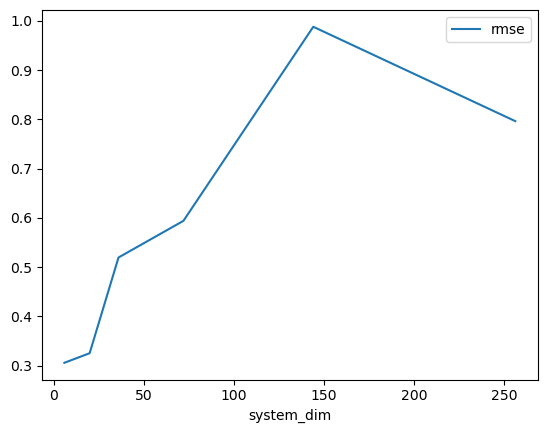

In [21]:
best_results_system_dim[['system_dim', 'rmse']].plot(x='system_dim', y='rmse')

<AxesSubplot: xlabel='system_dim'>

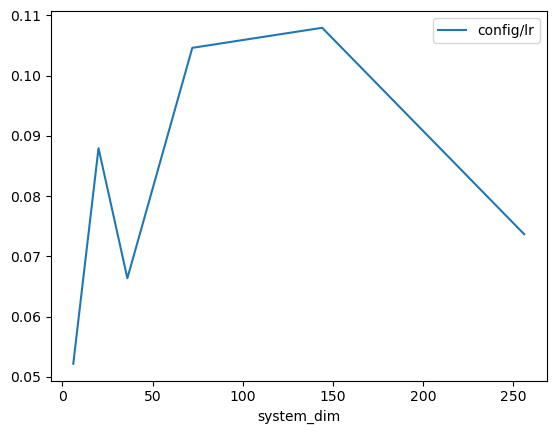

In [22]:
best_results_system_dim[['system_dim', 'config/lr']].plot(x='system_dim', y='config/lr')

<AxesSubplot: xlabel='system_dim'>

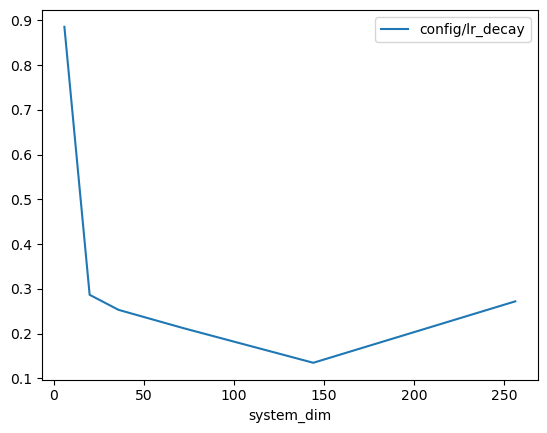

In [23]:
best_results_system_dim[['system_dim', 'config/lr_decay']].plot(x='system_dim', y='config/lr_decay')

### Repeat with varying error and num_obs

In [7]:
space = {
    "lr": hp.loguniform("lr", -8, -2),
    "lr_decay": hp.uniform("lr_decay", 0.1, 0.9),
}



In [8]:
all_results_df_list = []

num_runs = 1
system_dim = 36
num_obs_list = [6, 12, 18, 24, 30, 36]
obs_error_list = np.arange(0.1, 1.05, 0.1)
for obs_location_count in num_obs_list:
    for obs_sd in obs_error_list:
        trainable_with_system_dim = tune.with_parameters(train_backprop_4dvar, 
                                                         system_dim=system_dim,
                                                         num_obs=obs_location_count,
                                                         obs_sd=obs_sd
                                                         )
        hyperopt_search = HyperOptSearch(space, metric="rmse", mode="min")
        tuner = tune.Tuner(
            trainable_with_system_dim,
            tune_config=tune.TuneConfig(
                num_samples=20,
                search_alg=hyperopt_search,
            ),
        )
        results = tuner.fit()

        cur_results_df = results.get_dataframe()

        cur_results_df['system_dim'] = system_dim
        cur_results_df['num_obs'] = obs_location_count
        cur_results_df['obs_sd'] = obs_sd

        all_results_df_list.append(cur_results_df)
            

(train_backprop_4dvar pid=1842737) [[ 106.0560333   105.81608053  105.62700268] [repeated 2x across cluster]
(train_backprop_4dvar pid=1837927)  [116.30746168 101.56063876  94.4694652 ]
(train_backprop_4dvar pid=1842737)  [ 166.79498218  166.34637481  165.99287331] [repeated 6x across cluster]
(train_backprop_4dvar pid=1842737)  ... [repeated 2x across cluster]
(train_backprop_4dvar pid=1842737)  [2052.5615877  2046.58473689 2041.87102801]] [repeated 4x across cluster]
(train_backprop_4dvar pid=1842904)  [1506.09320033 1461.42293868 1450.283673  ]
(train_backprop_4dvar pid=1842904) [[ 106.0560333   103.31350136  102.63964346]
(train_backprop_4dvar pid=1842904)  [ 154.78409884  150.16954638  149.03552362] [repeated 2x across cluster]
(train_backprop_4dvar pid=1842904)  ...
(train_backprop_4dvar pid=1842904)  [1434.11205925 1391.82629522 1381.29327325]] [repeated 2x across cluster]
(train_backprop_4dvar pid=1843149)  ...
(train_backprop_4dvar pid=1843149)  [127.98352303 118.35103807 115.

2024-01-04 18:48:13,640	INFO tune.py:1047 -- Total run time: 80.79 seconds (80.74 seconds for the tuning loop).


In [24]:
full_results_df = pd.concat(all_results_df_list)
full_results_df.to_csv('./test_raytune_sgdopt_werrors_heatmap_v2.csv')

NameError: name 'all_results_df_list' is not defined

In [4]:
full_results_df_heatmap = pd.read_csv('./test_raytune_sgdopt_werrors_heatmap_v2.csv')

In [5]:
full_results_df_heatmap['trialnum'] = full_results_df_heatmap.index
full_results_df_heatmap.index = np.arange(full_results_df_heatmap.shape[0])

In [6]:
rows_to_get = full_results_df_heatmap.groupby(['num_obs','obs_sd']).idxmin()['rmse']

best_results_heatmap = full_results_df_heatmap.loc[rows_to_get]

/tmp/ipykernel_145056/247282580.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.idxmin is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rows_to_get = full_results_df_heatmap.groupby(['num_obs','obs_sd']).idxmin()['rmse']


In [8]:
best_results_heatmap

,Unnamed: 0,rmse,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,...,node_ip,time_since_restore,iterations_since_restore,config/lr,config/lr_decay,logdir,system_dim,num_obs,obs_sd,trialnum
1,1,3.752235,1704413573,NaN,False,1,b0ae50bb,2024-01-04_17-12-53,17.326727,17.326727,...,192.168.0.249,17.326727,1,0.001002,0.188332,b0ae50bb,36,6,0.1,1
13,10,3.558737,1704413771,NaN,False,1,d4cab4cd,2024-01-04_17-16-11,17.084189,17.084189,...,192.168.0.249,17.084189,1,0.009529,0.176302,d4cab4cd,36,6,0.2,13
28,11,3.546170,1704413862,NaN,False,1,dc7e03dd,2024-01-04_17-17-42,20.089625,20.089625,...,192.168.0.249,20.089625,1,0.017450,0.386369,dc7e03dd,36,6,0.3,28
47,13,3.668004,1704413994,NaN,False,1,451d11ad,2024-01-04_17-19-54,17.199093,17.199093,...,192.168.0.249,17.199093,1,0.058821,0.277573,451d11ad,36,6,0.4,47
54,5,3.671877,1704414046,NaN,False,1,43880cba,2024-01-04_17-20-46,17.656017,17.656017,...,192.168.0.249,17.656017,1,0.040783,0.441891,43880cba,36,6,0.5,54
80,12,3.443774,1704414172,NaN,False,1,2176eac4,2024-01-04_17-22-52,19.337439,19.337439,...,192.168.0.249,19.337439,1,0.050642,0.616799,2176eac4,36,6,0.6,80
104,16,3.654348,1704414289,NaN,False,1,ed79f91c,2024-01-04_17-24-49,19.840068,19.840068,...,192.168.0.249,19.840068,1,0.034281,0.646392,ed79f91c,36,6,0.7,104
113,5,3.646106,1704414349,NaN,False,1,73bfb931,2024-01-04_17-25-49,17.962125,17.962125,...,192.168.0.249,17.962125,1,0.101390,0.333928,73bfb931,36,6,0.8,113
132,4,3.680809,1704414446,NaN,False,1,775bd690,2024-01-04_17-27-26,17.514307,17.514307,...,192.168.0.249,17.514307,1,0.113697,0.112954,775bd690,36,6,0.9,132
160,12,3.683081,1704414582,NaN,False,1,0ffb8e43,2024-01-04_17-29-42,15.204866,15.204866,...,192.168.0.249,15.204866,1,0.109791,0.323213,0ffb8e43,36,6,1.0,160
